This is the Ultimate Oily Combo Platter Pizza order, even the kitchen sink was optioned in! Watch out buddies, this one might go crazy on them. 

Imports!

In [2]:

''' Standard Imports '''
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

''' SNS Imports '''
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render

''' MuJoCo Imports '''
import mujoco as mj
import mediapy as media

''' Other Necessary Imports '''
import numpy as np
import matplotlib.pyplot as plt
from random import randint, Random

ISI Code. Calculates the frequency of spikes!

In [3]:

# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

Motor Neuron activation code. Contains both random activation as well as manual. 

In [4]:

def randActivation(t, act_freq):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])
    
    act = 0b00

    for i in range(len(t)):
        if i % act_freq == 0:
            if act & 0b10:
                i_IN1[i-act_freq:i] += 1
            if act & 0b10:
                i_IN2[i-act_freq:i] += 1
            if act & 0b01:
                i_IN3[i-act_freq:i] += 1
            if act & 0b01:
                i_IN4[i-act_freq:i] += 1
            
            act = randint(0, 3)
    
    return i_IN1, i_IN2, i_IN3, i_IN4

def manualActivation(t, active_inputs):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    if active_inputs & 0b1000:
        i_IN1 += 1
    if active_inputs & 0b0100:
        i_IN2 += 1
    if active_inputs & 0b0010:
        i_IN3 += 1
    if active_inputs & 0b0001:
        i_IN4 += 1
    
    return i_IN1, i_IN2, i_IN3, i_IN4

def randActivation2(t, pair_freq, indi_freq):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    # Initilize at 0b00
    pair_act = 0b00
    indi_act1 = 0b00
    indi_act2 = 0b00

    for i in range(len(t)):
        if pair_act & 0b01:
            if indi_act1 & 0b01:
                i_IN1[i] += 1
            if indi_act1 & 0b10:
                i_IN2[i] += 1

        if pair_act & 0b10:
            if indi_act2 & 0b01:
                i_IN3[i] += 1
            if indi_act2 & 0b10:
                i_IN4[i] += 1

        if i % pair_freq == 0:
            pair_act = randint(0, 3)
            
        if i % indi_freq == 0:
            indi_act1 = randint(0, 3)
            indi_act2 = randint(0, 3)
    return i_IN1, i_IN2, i_IN3, i_IN4

def manualActivation2(t, split_ms):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    active = 1

    for i in range(len(t)):
        if active == 0:
            i_IN1[i] += 1 
            i_IN2[i] += 1

        if active == 1:
            i_IN3[i] += 1
            i_IN4[i] += 1
    
        if t[i] % split_ms == 0:
            active = not active

    return i_IN1, i_IN2, i_IN3, i_IN4

def manualActivation3(t, on_time, off_time):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    # Converting from ms on and off time to timestep on and off time
    on_time = on_time * 10
    off_time = off_time * 10

    active = 0
    on_counter = 0
    off_counter = 0

    ts1 = 0
    ts2 = 0
    ts3 = 0
    ts4 = 0

    for i in range(len(t)):
        if active == 0:
            i_IN1[i] += 1
            i_IN2[i] += 1
            ts1 += 1
        if active == 1:
            ts2 += 1
        if active == 2:
            i_IN3[i] += 1
            i_IN4[i] += 1
            ts3 += 1
        if active == 3:
            ts4 += 1

        if active == 0 or active == 2:
            on_counter += 1
        if active == 1 or active == 3:
            off_counter += 1

        if on_counter == on_time:
            on_counter = 0
            active += 1
        if off_counter == off_time:
            off_counter = 0
            active += 1

        if active >= 4:
            active = 0

    return i_IN1, i_IN2, i_IN3, i_IN4



Random conductance value generator for synapses. 

In [5]:

''' Produces 8 random conductances for the 8 connections between the INs and the POSTs'''
def randConnectionCond(seed='AUGGGH', g_min=2.99, g_max=5.98):
    rng = Random(x=seed)
    '''
    For Conductances
    2.99 is a barely spikes the post when paired.
    g_max is for solo spiking. 
    '''
    g_min = int(g_min * 100) # Convert to int
    g_max = int(g_max * 100) # Convert to int

    # Generating two arrays for the 2 connection arrays needed for g_update
    g_POST1 = []
    g_POST2 = []

    for i in range(4):
        g_POST1.append(rng.randint(g_min, g_max) / 100) # Get rand int, convert back to float
        g_POST2.append(rng.randint(g_min, g_max) / 100)
    for i in range(2):
        g_POST1.append(0.0)
        g_POST2.append(0.0)
    
    return g_POST1, g_POST2

STDP modification window function.

In [6]:

''' Implements the STDP window. Send your time difference, get some LTP / LTD '''
def weightUpdate(dt_array):
    A_pos = 0.1 # Max potentiation level
    A_neg = 0.25 # Max Depression value
    tou_pos = 10.0 # ms. Decay time constant for potentiation
    tou_neg = 11.0 # ms. Decay time constant for depression
    weight_change = []

    for dt in dt_array:
        if dt == None:
            weight_change.append(0.0)
        else:
            # If dt is positive, that means that the postsynaptic neuron spiked before the presynaptic. DEPRESSION
            if dt > 0:
                weight_change.append(-A_neg * np.exp(-dt / tou_neg))
            # If dt is negative, that means the presynaptic neuron spiked before the postsynaptic. POTENTIATION
            if dt <= 0:
                weight_change.append(A_pos * np.exp(dt / tou_pos))
    return weight_change

Ia Feedback to Current.

In [7]:

''' Takes a scalar velocity feedback from MuJoCo and converts to scalar current value '''
# Takes the 0 to 1.0 velocity readings and returns 0 to 1.1 nA 
def vel2cur(velocity):
    return (1.000 + 0.1*velocity)

Import XML File of Test Leg.

""

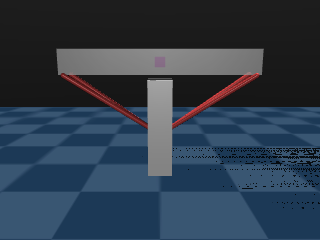

In [8]:

''' Load MuJoCo File '''
# Load model
mjmodel = mj.MjModel.from_xml_path('C:/Users/markpup/SNNCode/MJ_Leg.xml')
mjdata = mj.MjData(mjmodel)
# Create MuJoCo renderer
renderer = mj.Renderer(mjmodel)

# Show image of XML file for reference
mj.mj_forward(mjmodel, mjdata)
renderer.update_scene(mjdata, camera='fixed')
media.show_image(renderer.render())
renderer.close() # Needed to prevent crashing?

Parameters for Neural Networks and MuJoCo simulation.

In [9]:

''' SNS Parameters '''
sns_dt = 0.1 # ms
sns_tmax = 100000 # ms
sns_t = np.arange(0, sns_tmax, sns_dt)

''' MuJoCo Parameters '''
mj_dt = sns_dt / 1000 # Converts to seconds. essentially 0.0001 s
mj_tmax = sns_tmax / 1000 # Converts to seconds. essentially 10.000 s
mj_t = np.arange(0, mj_tmax, mj_dt)

framerate = 60 # fps for movie capture

Motor Neuron Network Creation.

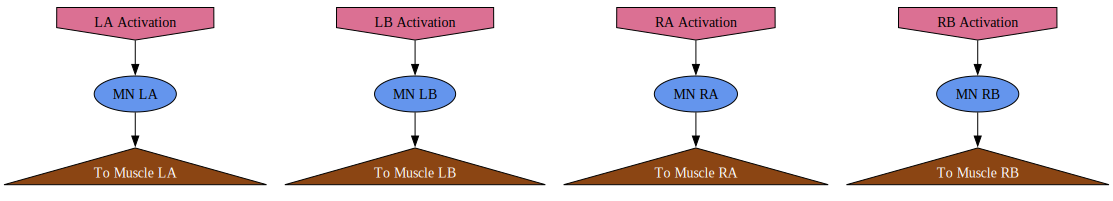

In [10]:

''' SNS-TOOLBOX Motor Neuron Network '''
# Create base network
mn_net = Network()

# Initilize spiking neuron
spiking_mn = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)

# Add spiking motor neurons
mn_net.add_neuron(spiking_mn, name='MN LA', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN LB', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN RA', color='cornflowerblue')
mn_net.add_neuron(spiking_mn, name='MN RB', color='cornflowerblue')

# Add inputs
mn_net.add_input(dest='MN LA', name='LA Activation', color='palevioletred')
mn_net.add_input(dest='MN LB', name='LB Activation', color='palevioletred')
mn_net.add_input(dest='MN RA', name='RA Activation', color='palevioletred')
mn_net.add_input(dest='MN RB', name='RB Activation', color='palevioletred')

# Add outputs
mn_net.add_output(source='MN LA', name='To Muscle LA', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN LB', name='To Muscle LB', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN RA', name='To Muscle RA', color='saddlebrown', spiking=True)
mn_net.add_output(source='MN RB', name='To Muscle RB', color='saddlebrown', spiking=True)

# Render network
render(mn_net, view=True)

Compile Motor Neural Network.

In [11]:

# Compile MN Network using standard SNS backend
sns_mn_network = mn_net.compile(dt=sns_dt, backend='numpy_standard', debug=False)

Learning Neural Network Creation.

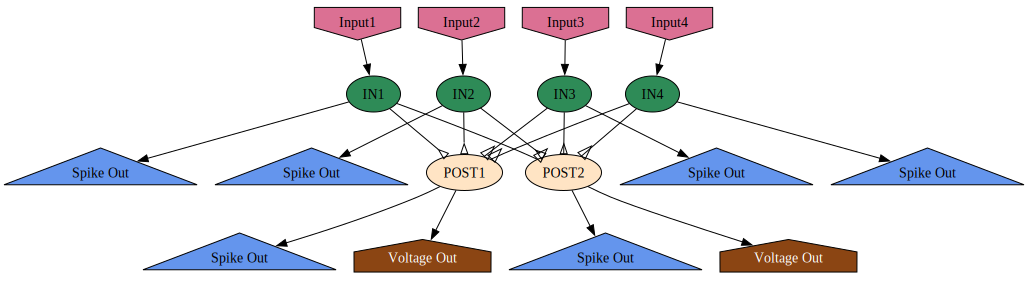

In [12]:

''' Adaptive learning network. Where the learning happens '''
# Base network for neurons
net = Network()

# Standard, plain presynaptic spiking neuron
pre_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0,
)

# standard plan post synaptic neuron
post_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)

# Only one synapse needs to be defined. The inidividual connection values will be modified later.
stdp_synapse = SpikingSynapse(
    reversal_potential=2.0,
    max_conductance=5.0
)

# Presynaptic Neurons (INs)
net.add_neuron(pre_neuron, name='IN1', color='seagreen')
net.add_neuron(pre_neuron, name='IN2', color='seagreen')
net.add_neuron(pre_neuron, name='IN3', color='seagreen')
net.add_neuron(pre_neuron, name='IN4', color='seagreen')
# Postsynaptic Neurons (POSTs)
net.add_neuron(post_neuron, name='POST1', color='bisque')
net.add_neuron(post_neuron, name='POST2', color='bisque')
# Order of addition of neurons. List of names to use later
neuron_list = ['IN1', 'IN2', 'IN3', 'IN4', 'POST1', 'POST2']
# Connections
net.add_connection(stdp_synapse, source='IN1', destination='POST1')
net.add_connection(stdp_synapse, source='IN1', destination='POST2')

net.add_connection(stdp_synapse, source='IN2', destination='POST1')
net.add_connection(stdp_synapse, source='IN2', destination='POST2')

net.add_connection(stdp_synapse, source='IN3', destination='POST1')
net.add_connection(stdp_synapse, source='IN3', destination='POST2')

net.add_connection(stdp_synapse, source='IN4', destination='POST1')
net.add_connection(stdp_synapse, source='IN4', destination='POST2')
# Inputs
net.add_input(dest='IN1', name='Input1', color='palevioletred')
net.add_input(dest='IN2', name='Input2', color='palevioletred')
net.add_input(dest='IN3', name='Input3', color='palevioletred')
net.add_input(dest='IN4', name='Input4', color='palevioletred')
# Outputs
# POST Outputs
net.add_output(source='POST1', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='POST1', name='Voltage Out', spiking=False, color='saddlebrown')
net.add_output(source='POST2', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='POST2', name='Voltage Out', spiking=False, color='saddlebrown')
# IN Outputs
net.add_output(source='IN1', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN2', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN3', name='Spike Out', spiking=True, color='cornflowerblue')
net.add_output(source='IN4', name='Spike Out', spiking=True, color='cornflowerblue')
# Order of addition of outputs for plotting reference
output_list = ['Interneuron 1 Spike', 'Interneuron 1 Voltage', 'Interneuron 2 Spike', 'Interneuron 2 Voltage', 'FB1 Spike', 'FB2 Spike', 'FB3 Spike', 'FB4 Spike']

# Render the network
render(net)

Compile Learning Neural Network.

In [13]:

# Compile Learning Neural Netowkr using modified SNS backend
sns_stdp_network = net.compile(dt=sns_dt, backend='numpy', debug=False)

Initialize Synaptic Connection with Random Values.

In [14]:

''' Builds matrix necessary for synaptic connections '''
# Inilizes matrix of the right size
g_update = np.zeros([net.get_num_neurons(), net.get_num_neurons()]) + sns_stdp_network.__dict__.get('g_max_spike')
g_POST1 = np.zeros([1, net.get_num_neurons()])
g_POST2 = np.zeros([1, net.get_num_neurons()])

'''
For Conductances
2.99 is a barely spikes the post when paired.
5.98 is for solo spiking. 
'''
g_max = 4.5
g_floor = 0.0

# Assigning values to connectivity of synapses
g_POST1, g_POST2 = randConnectionCond(seed=randint(0, 1000000000), g_max=g_max, g_min=0.50)

# Manual input values if needed
g_POST1 = [4.5, 1.5, 4.5, 1.0, 0, 0]
g_POST2 = [1.5, 2.98, 2.5, 4.5, 0, 0]

# Pulling out inidividual conductances in order to modify later on
IN1_to_POST1 = g_POST1[0]
IN2_to_POST1 = g_POST1[1]
IN3_to_POST1 = g_POST1[2]
IN4_to_POST1 = g_POST1[3]

IN1_to_POST2 = g_POST2[0]
IN2_to_POST2 = g_POST2[1]
IN3_to_POST2 = g_POST2[2]
IN4_to_POST2 = g_POST2[3]

# Placing synapse values in the g_update to send to backend
g_update[-2] = g_POST1
g_update[-1] = g_POST2

# Printing post modification values if needed
# print(g_update)
g_start = np.copy(g_update)

Initialize STDP Variables.

In [15]:

''' Variables needed for STDP Code '''
# Creating variable to store inputs
sns_stdp_inputs = np.zeros([len(sns_t), net.get_num_inputs()])
# Creating variable to store output data
stdp_data = np.zeros([len(sns_t), net.get_num_outputs_actual()])


# Initilize spike condition
IN1_spike_last = 0
IN2_spike_last = 0
IN3_spike_last = 0
IN4_spike_last = 0
POST1_spike_last = 0
POST2_spike_last = 0
update_g = 0

# Set up arrays for plotting changing conductances
plot_IN1_t = [0.0]
plot_IN2_t = [0.0]
plot_IN3_t = [0.0]
plot_IN4_t = [0.0]
plot_IN1_POST1 = [IN1_to_POST1]
plot_IN2_POST1 = [IN2_to_POST1]
plot_IN3_POST1 = [IN3_to_POST1]
plot_IN4_POST1 = [IN4_to_POST1]
plot_IN1_POST2 = [IN1_to_POST2]
plot_IN2_POST2 = [IN2_to_POST2]
plot_IN3_POST2 = [IN3_to_POST2]
plot_IN4_POST2 = [IN4_to_POST2]

Initialize Motor Neuron Variables.

In [16]:

''' Variables necessary for MN Code '''
# Variables to store sensor data
len_la = []
len_lb = []
len_ra = []
len_rb = []

vel_la = []
vel_lb = []
vel_ra = []
vel_rb = []

# Current from velocity sensors
i_out_la = np.zeros([len(sns_t), 1])
i_out_lb = np.zeros([len(sns_t), 1])
i_out_ra = np.zeros([len(sns_t), 1])
i_out_rb = np.zeros([len(sns_t), 1])

# Inputs to SNS
sns_mn_inputs = np.zeros([len(sns_t), mn_net.get_num_inputs()])

# Data collected from sns
mn_data = np.zeros([len(sns_t), mn_net.get_num_outputs_actual()])

''' Set Inputs to Muscles '''
# Set up variables
la_act = 0.0
lb_act = 0.0
ra_act = 0.0
rb_act = 0.0

# Assigning injected current to motor neurons
mn1, mn2, mn3, mn4 = randActivation2(sns_t, 10000, 2000) # This is i steps, so 1 second pair, 0.2 second individual
# mn1, mn2, mn3, mn4 = manualActivation(sns_t, 11)
''' 1&2 On, All Off, 3&4 On, All Off '''
# mn1, mn2, mn3, mn4 = manualActivation3(sns_t, 1000, 1000)

sns_mn_inputs[:,0] = mn1 * 1.05
sns_mn_inputs[:,1] = mn2 * 1.05
sns_mn_inputs[:,2] = mn3 * 1.05
sns_mn_inputs[:,3] = mn4 * 1.05

Initialize MuJoCo Variables.

In [17]:

''' Variables for MuJoCo and Resetting Model '''
# Set up frame capturing variables
frames = []

# Reset simulation
mj.mj_resetData(mjmodel, mjdata)

# Restart renderer
renderer = mj.Renderer(mjmodel)

Simulation of SNS network and MuJoCo. Bringing it all together!

In [18]:

''' Steps through the simulation time, running (in order) MN SNS, MuJoCo, STDP SNS '''
for i in range(len(sns_t)):
    ''' MN SNS '''
    mn_data[i,:] = sns_mn_network(sns_mn_inputs[i,:])

    ''' Spiking Motor Neuron === Muscle Activation '''
    if sum(sns_mn_network.__dict__.get('spikes')) != 0:
        mn_spike = sns_mn_network.__dict__.get('spikes')
        # If a spike occured for a specific motor, activate it for a single timestep
        if mn_spike[0] != 0:
            mjdata.act[0] = 2
        if mn_spike[1] != 0:
            mjdata.act[1] = 2
        if mn_spike[2] != 0:
            mjdata.act[2] = 2
        if mn_spike[3] != 0:
            mjdata.act[3] = 2
    # Keep muscles deactivated if no spiking exists
    else:
        mjdata.act[0] = 0.0
        mjdata.act[1] = 0.0
        mjdata.act[2] = 0.0
        mjdata.act[3] = 0.0
    
    ''' Advance MuJoCo Simulation '''
    mj.mj_step(mjmodel, mjdata)

    # Capture frame data if it corresponds to framerate demands
    if len(frames) < mjdata.time*framerate:
        renderer.update_scene(mjdata, camera='fixed')
        pixels = renderer.render().copy()
        frames.append(pixels)
    
    # Record sensor data from MuJoCo
    # In XML, sensors ordered as length (la lb ra rb) [0 - 3] velocity (la lb ra rb) [4 - 7]
    len_la.append(mjdata.sensordata[0])
    len_lb.append(mjdata.sensordata[1])
    len_ra.append(mjdata.sensordata[2])
    len_rb.append(mjdata.sensordata[3])

    vel_la.append(mjdata.sensordata[4])
    vel_lb.append(mjdata.sensordata[5])
    vel_ra.append(mjdata.sensordata[6])
    vel_rb.append(mjdata.sensordata[7])

    # Convert output 1a feedback (velocity, scalar) to input current to neuron within desired range
    i_out_la[i] = vel2cur(vel_la[i])
    i_out_lb[i] = vel2cur(vel_lb[i])
    i_out_ra[i] = vel2cur(vel_ra[i])
    i_out_rb[i] = vel2cur(vel_rb[i])

    ''' STDP Network '''
    # Assign Ia current from MuJoCo to STDP network inputs
    sns_stdp_inputs[i,0] = i_out_la[i,0]
    sns_stdp_inputs[i,1] = i_out_lb[i,0]
    sns_stdp_inputs[i,2] = i_out_ra[i,0]
    sns_stdp_inputs[i,3] = i_out_rb[i,0]

    # Step forward STDP SNS network simulation
    stdp_data[i,:] = sns_stdp_network(sns_stdp_inputs[i,:], current_time=sns_t[i], dt=sns_dt, g_update=g_update)

    ''' STDP Modification Code '''
    # Update conductance values from the LAST loop's spiking condition
    ''' LTD '''
    if IN1_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(sns_stdp_network.__dict__.get('IN1_spike_diff'))

        # Update conductance value to specific connections
        IN1_to_POST1 = IN1_to_POST1 + ltd1
        IN1_to_POST2 = IN1_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN1_to_POST1 < g_floor:
            IN1_to_POST1 = g_floor
        if IN1_to_POST2 < g_floor:
            IN1_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN1_t.append(sns_t[i])
        plot_IN1_POST1.append(IN1_to_POST1)
        plot_IN1_POST2.append(IN1_to_POST2)

        # Reset spiking condition
        IN1_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN2_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(sns_stdp_network.__dict__.get('IN2_spike_diff'))

        # Update conductance value to specific connections
        IN2_to_POST1 = IN2_to_POST1 + ltd1
        IN2_to_POST2 = IN2_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN2_to_POST1 < g_floor:
            IN2_to_POST1 = g_floor
        if IN2_to_POST2 < g_floor:
            IN2_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN2_t.append(sns_t[i])
        plot_IN2_POST1.append(IN2_to_POST1)
        plot_IN2_POST2.append(IN2_to_POST2)

        # Reset spiking condition
        IN2_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN3_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(sns_stdp_network.__dict__.get('IN3_spike_diff'))

        # Update conductance value to specific connections
        IN3_to_POST1 = IN3_to_POST1 + ltd1
        IN3_to_POST2 = IN3_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN3_to_POST1 < g_floor:
            IN3_to_POST1 = g_floor
        if IN3_to_POST2 < g_floor:
            IN3_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN3_t.append(sns_t[i])
        plot_IN3_POST1.append(IN3_to_POST1)
        plot_IN3_POST2.append(IN3_to_POST2)

        # Reset spiking condition
        IN3_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if IN4_spike_last == -1:
        # Use time IN1 spiked after POST1 and POST2 to find conductivity modification amount
        ltd1, ltd2 = weightUpdate(sns_stdp_network.__dict__.get('IN4_spike_diff'))

        # Update conductance value to specific connections
        IN4_to_POST1 = IN4_to_POST1 + ltd1
        IN4_to_POST2 = IN4_to_POST2 + ltd2

        # Check to ensure conductance is not below the floor value
        if IN4_to_POST1 < g_floor:
            IN4_to_POST1 = g_floor
        if IN4_to_POST2 < g_floor:
            IN4_to_POST2 = g_floor

        # Save weight update to plot later
        plot_IN4_t.append(sns_t[i])
        plot_IN4_POST1.append(IN4_to_POST1)
        plot_IN4_POST2.append(IN4_to_POST2)

        # Reset spiking condition
        IN4_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    ''' LTP '''
    if POST1_spike_last == -1:
        # Use time POST1 spiked after IN1, IN2, IN3, IN4 to find weight updates
        ltp1, ltp2, ltp3, ltp4 = weightUpdate(sns_stdp_network.__dict__.get('POST1_spike_diff'))

        # Apply weight updates
        IN1_to_POST1 = IN1_to_POST1 + ltp1
        IN2_to_POST1 = IN2_to_POST1 + ltp2
        IN3_to_POST1 = IN3_to_POST1 + ltp3
        IN4_to_POST1 = IN4_to_POST1 + ltp4

        # Ensuring none of the values have crossed the max value
        if IN1_to_POST1 > g_max:
            IN1_to_POST1 = g_max
        if IN2_to_POST1 > g_max:
            IN2_to_POST1 = g_max
        if IN3_to_POST1 > g_max:
            IN3_to_POST1 = g_max
        if IN4_to_POST1 > g_max:
            IN4_to_POST1 = g_max

        # Reset spiking condition
        POST1_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    if POST2_spike_last == -1:
        # Use time POST2 spiked after IN1, IN2, IN3, IN4 to find weight updates
        ltp1, ltp2, ltp3, ltp4 = weightUpdate(sns_stdp_network.__dict__.get('POST2_spike_diff'))

        # Apply weight updates
        IN1_to_POST2 = IN1_to_POST2 + ltp1
        IN2_to_POST2 = IN2_to_POST2 + ltp2
        IN3_to_POST2 = IN3_to_POST2 + ltp3
        IN4_to_POST2 = IN4_to_POST2 + ltp4

        # Ensuring none of the values have crossed the max value
        if IN1_to_POST2 > g_max:
            IN1_to_POST2 = g_max
        if IN2_to_POST2 > g_max:
            IN2_to_POST2 = g_max
        if IN3_to_POST2 > g_max:
            IN3_to_POST2 = g_max
        if IN4_to_POST2 > g_max:
            IN4_to_POST2 = g_max

        # Reset spiking condition
        POST2_spike_last = 0
        # Trigger a conductance update
        update_g = 1

    # Update conductance array
    if update_g == 1:
        # Update conductance values
        g_POST1 = [IN1_to_POST1, IN2_to_POST1, IN3_to_POST1, IN4_to_POST1, 0, 0]
        g_POST2 = [IN1_to_POST2, IN2_to_POST2, IN3_to_POST2, IN4_to_POST2, 0, 0]
        # Placing synapse values in the g_update to send to backend
        g_update[-2] = g_POST1
        g_update[-1] = g_POST2
        # Reset update command
        update_g = 0

    # Check this loops spiking conditions
    if sum(sns_stdp_network.__dict__.get('spikes')) != 0:
        spikes = sns_stdp_network.__dict__.get('spikes')
        IN1_spike_last = spikes[0]
        IN2_spike_last = spikes[1]
        IN3_spike_last = spikes[2]
        IN4_spike_last = spikes[3]
        POST1_spike_last = spikes[4]
        POST2_spike_last = spikes[5]

# Transpose the data to put in necessary form for plotting
mn_data = mn_data.transpose()
stdp_data = stdp_data.transpose()

# Close the renderer for safety
renderer.close()

Play Video of Simulation.

In [19]:

# Play MuJoCo video
media.show_video(frames, fps=framerate)

Calculating spiking frequency of motor neurons. 

In [20]:

''' Calculating interspike interval for Motor Neurons '''
mn_la_freq, mn_la_loc = getFreq(data=mn_data[0,:], dt=sns_dt)
mn_lb_freq, mn_lb_loc = getFreq(data=mn_data[1,:], dt=sns_dt)
mn_ra_freq, mn_ra_loc = getFreq(data=mn_data[2,:], dt=sns_dt)
mn_rb_freq, mn_rb_loc = getFreq(data=mn_data[3,:], dt=sns_dt)

''' Calculating interspike interval for Ia afferents '''
IN1_freq, IN1_loc = getFreq(data=stdp_data[4,:], dt=sns_dt)
IN2_freq, IN2_loc = getFreq(data=stdp_data[5,:], dt=sns_dt)
IN3_freq, IN3_loc = getFreq(data=stdp_data[6,:], dt=sns_dt)
IN4_freq, IN4_loc = getFreq(data=stdp_data[7,:], dt=sns_dt)

''' Calculating interspike interval for Interneurons '''
POST1_frequency, POST1_loc = getFreq(data=stdp_data[0,:], dt=sns_dt)
POST2_frequency, POST2_loc = getFreq(data=stdp_data[2,:], dt=sns_dt)

# Fixing empty array warnings
if len(POST1_frequency) > 1:
    POST1_avg = np.round(np.average(POST1_frequency), 2)
else:
    POST1_avg = np.zeros(1)
if len(POST2_frequency) > 1:
    POST2_avg = np.round(np.average(POST2_frequency), 2)
else:
    POST2_avg = np.zeros(1)

# Creating a cool and stylish label!
freq_label = ['POST1 Spike AVG: ' + str(POST1_avg) + 'Hz', 'POST2 Spike AVG: ' + str(POST2_avg)+ 'Hz']


Plot limit definitions.

In [21]:

# Set x limits so plots can be adjusted accoring to desired
plot_x_min = 0
plot_x_max_mj  = mj_tmax /20
plot_x_max_sns = sns_tmax /20

Plot of MN Network activity.

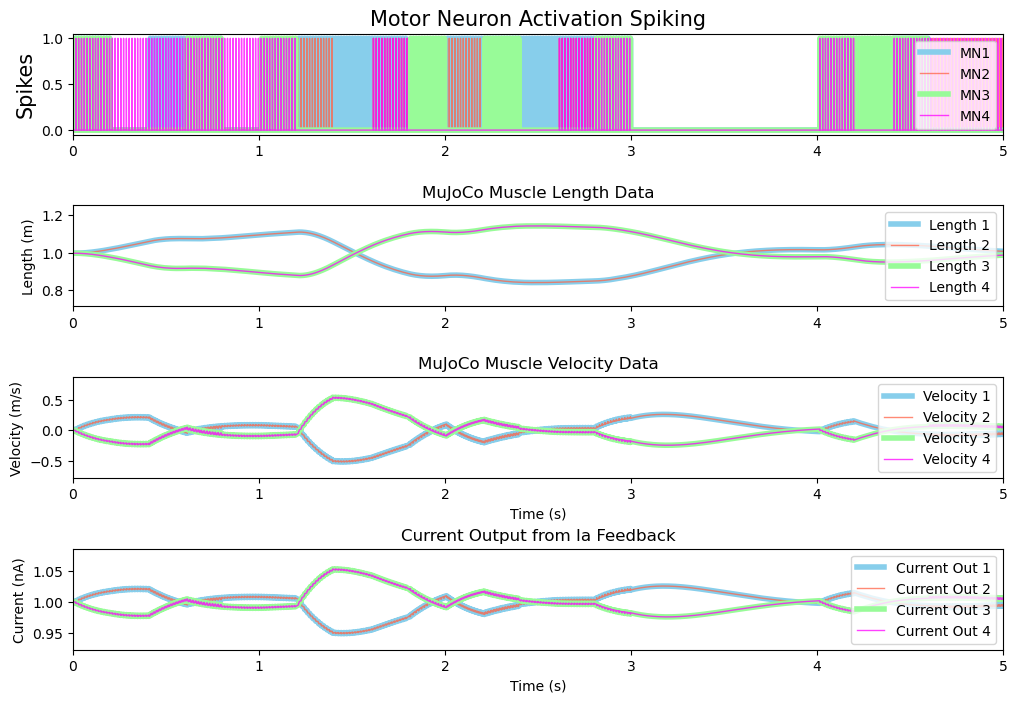

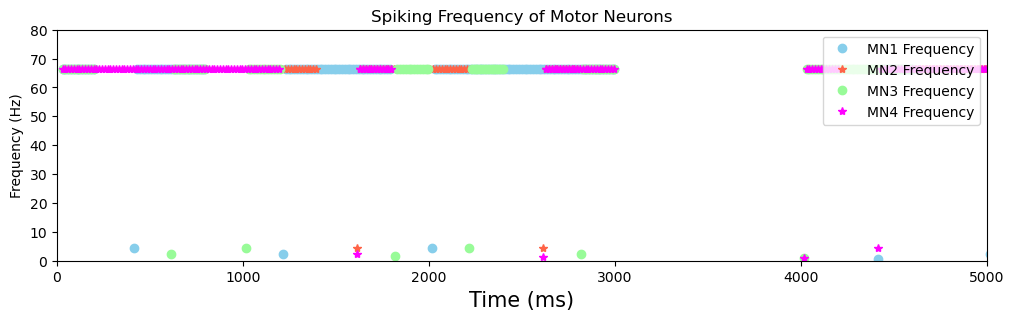

In [22]:

# Set of colors to be used across all plots for consistency
colors = ['skyblue', 'tomato', 'palegreen', 'fuchsia']


''' Spiking Motor Neuron Plots '''
plt.figure(figsize=[12, 8]) # 27, 12

plt.subplot(4, 1, 1)
plt.subplots_adjust(hspace=0.70)
plt.plot(sns_t, mn_data[0,:], label='MN1', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(sns_t, mn_data[1,:], label='MN2', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(sns_t, mn_data[2,:], label='MN3', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(sns_t, mn_data[3,:], label='MN4', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('Motor Neuron Activation Spiking', size='15')
plt.ylabel('Spikes', size='15')
# plt.xlabel('Time (s)')
plt.xticks(ticks=[0, 1000, 2000, 3000, 4000, 5000], labels=[0, 1, 2, 3, 4, 5])
plt.xlim(plot_x_min, plot_x_max_sns)

''' Muscle Length Data '''
plt.subplot(4, 1, 2)
plt.plot(mj_t, len_la, label='Length 1', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mj_t, len_lb, label='Length 2', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mj_t, len_ra, label='Length 3', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mj_t, len_rb, label='Length 4', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('MuJoCo Muscle Length Data')
plt.ylabel('Length (m)')
# plt.xlabel('Time (s)')
plt.xlim(plot_x_min, plot_x_max_mj)

plt.subplot(4, 1, 3)
plt.plot(mj_t, vel_la, label='Velocity 1', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mj_t, vel_lb, label='Velocity 2', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mj_t, vel_ra, label='Velocity 3', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mj_t, vel_rb, label='Velocity 4', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('MuJoCo Muscle Velocity Data')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.xlim(plot_x_min, plot_x_max_mj)

''' Plotting current output '''
plt.subplot(4, 1, 4)
plt.plot(mj_t, i_out_la, label='Current Out 1', color=colors[0], alpha=1.00, linewidth=4)
plt.plot(mj_t, i_out_lb, label='Current Out 2', color=colors[1], alpha=0.75, linewidth=1)
plt.plot(mj_t, i_out_ra, label='Current Out 3', color=colors[2], alpha=1.00, linewidth=4)
plt.plot(mj_t, i_out_rb, label='Current Out 4', color=colors[3], alpha=0.75, linewidth=1)
plt.legend(loc='upper right')
plt.title('Current Output from Ia Feedback')
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')
plt.xlim(plot_x_min, plot_x_max_mj)

plt.savefig('MuJoCoData.png', dpi=600)

plt.show()

''' Plotting spike frequency of Motor Neurons '''
plt.figure(figsize=[12, 3]) # 27, 3
plt.plot(mn_la_loc, mn_la_freq, 'o', color=colors[0], label='MN1 Frequency')
plt.plot(mn_lb_loc, mn_lb_freq, '*', color=colors[1], label='MN2 Frequency')
plt.plot(mn_ra_loc, mn_ra_freq, 'o', color=colors[2], label='MN3 Frequency')
plt.plot(mn_rb_loc, mn_rb_freq, '*', color=colors[3], label='MN4 Frequency')
plt.legend(loc='upper right')
plt.title('Spiking Frequency of Motor Neurons')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)', size='15')
plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylim(0, 80)

plt.show()

Plot of STDP Network Activity.

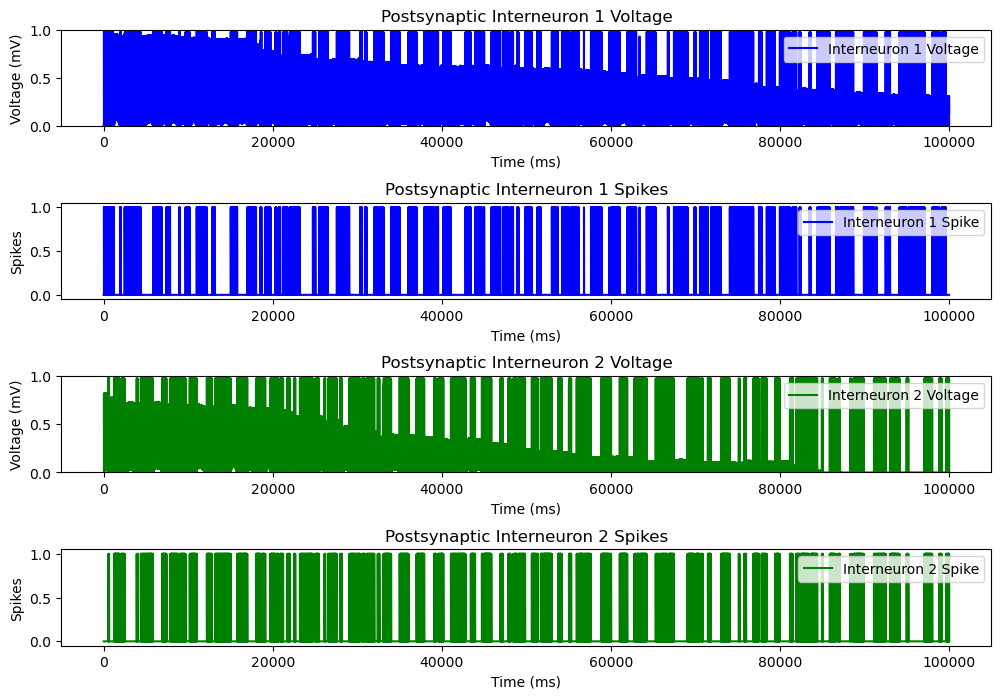

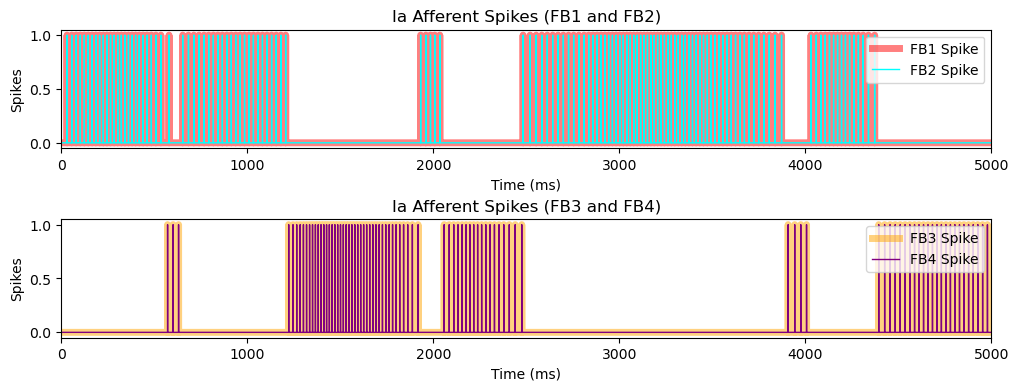

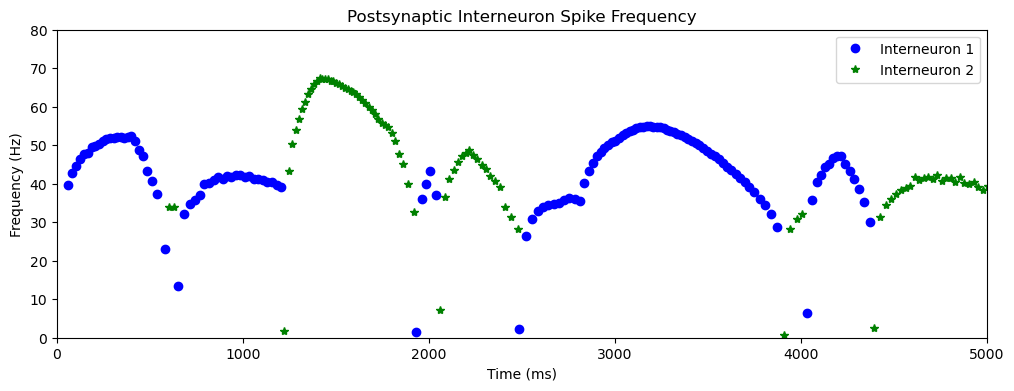

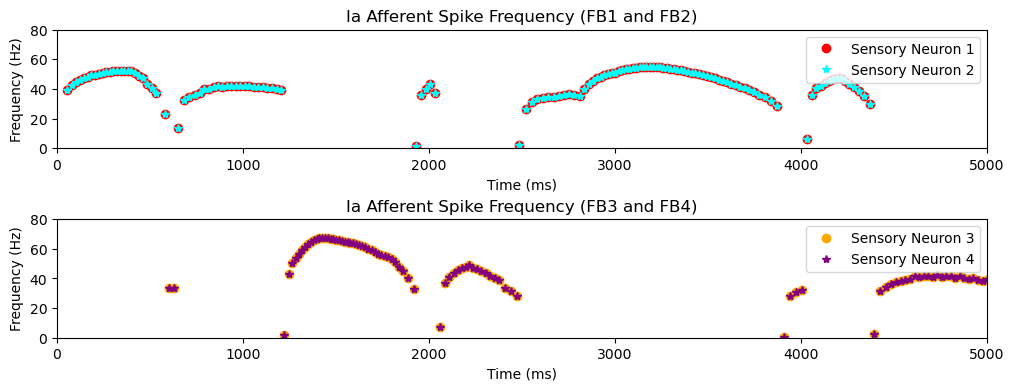

In [23]:

''' Postsynaptic Data Plots '''
plt.figure(figsize=[12, 8]) # 27, 12
# Postsynaptic 1 Voltage
plt.subplot(4, 1, 1)
plt.subplots_adjust(hspace=0.8)
plt.plot(sns_t, stdp_data[1,:], label=output_list[1], color='blue')
plt.legend(loc='upper right')
plt.ylim(0, 1)
# plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.title('Postsynaptic Interneuron 1 Voltage')
# Postsynaptic 1 Spikes
plt.subplot(4, 1, 2)
plt.plot(sns_t, stdp_data[0,:], label=output_list[0], color='blue')
plt.legend(loc='upper right')
# plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Spikes')
plt.xlabel('Time (ms)')
plt.title('Postsynaptic Interneuron 1 Spikes')
# Postsynaptic 2 Voltage
plt.subplot(4, 1, 3)
plt.plot(sns_t, stdp_data[3,:], label=output_list[3], color='green')
plt.legend(loc='upper right')
plt.ylim(0, 1)
# plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')
plt.title('Postsynaptic Interneuron 2 Voltage')
# Postsynaptic 2 Spikes
plt.subplot(4, 1, 4)
plt.plot(sns_t, stdp_data[2,:], label=output_list[2], color='green')
plt.legend(loc='upper right')
# plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Spikes')
plt.xlabel('Time (ms)')
plt.title('Postsynaptic Interneuron 2 Spikes')

plt.show()

''' Ia Afferent Spike Plots '''
plt.figure(figsize=[12, 4]) # 27, 7
# Afferents 1 and 2
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.6)
plt.plot(sns_t, stdp_data[4,:], '-', alpha=0.5, color='red', linewidth=5, label=output_list[4])
plt.plot(sns_t, stdp_data[5,:], '-', alpha=1.0, color='cyan', linewidth=1, label=output_list[5])
plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Spikes')
plt.xlabel('Time (ms)')
plt.title('Ia Afferent Spikes (FB1 and FB2)')
plt.legend(loc='upper right')
# Afferents 3 and 4
plt.subplot(2, 1, 2)
plt.plot(sns_t, stdp_data[6,:], '-', alpha=0.5, color='orange', linewidth=5, label=output_list[6])
plt.plot(sns_t, stdp_data[7,:], '-', alpha=1.0, color='purple', linewidth=1, label=output_list[7])
plt.xlim(plot_x_min, plot_x_max_sns)
plt.ylabel('Spikes')
plt.xlabel('Time (ms)')
plt.title('Ia Afferent Spikes (FB3 and FB4)')
plt.legend(loc='upper right')
plt.show()

''' Postsynaptic Spike Frequency Plot '''
plt.figure(figsize=[12, 4]) # 27, 7
plt.plot(POST1_loc, POST1_frequency, 'o', color='blue', label='Interneuron 1')
plt.plot(POST2_loc, POST2_frequency, '*', color='green', label='Interneuron 2')
plt.legend(loc='upper right')
plt.title('Postsynaptic Interneuron Spike Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.ylim(0, 80)
plt.xlim(plot_x_min, plot_x_max_sns)
plt.show()

''' Ia Afferent Spike Frequency Plot '''
# IN1 and IN2 Spike Frequency
plt.figure(figsize=[12, 4]) # 27, 7
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.6)
plt.plot(IN1_loc, IN1_freq, 'o', color='red', label='Sensory Neuron 1')
plt.plot(IN2_loc, IN2_freq, '*', color='cyan', label='Sensory Neuron 2')
plt.title('Ia Afferent Spike Frequency (FB1 and FB2)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.ylim(0, 80)
plt.xlim(plot_x_min, plot_x_max_sns)
plt.legend(loc='upper right')
# IN3 and IN4 Spike Frequency
plt.subplot(2, 1, 2)
plt.plot(IN3_loc, IN3_freq, 'o', color='orange', label='Sensory Neuron 3')
plt.plot(IN4_loc, IN4_freq, '*', color='purple', label='Sensory Neuron 4')
plt.title('Ia Afferent Spike Frequency (FB3 and FB4)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
plt.ylim(0, 80)
plt.xlim(plot_x_min, plot_x_max_sns)
plt.legend(loc='upper right')

plt.show()


Plot of change in synaptic conductance values across simulation.

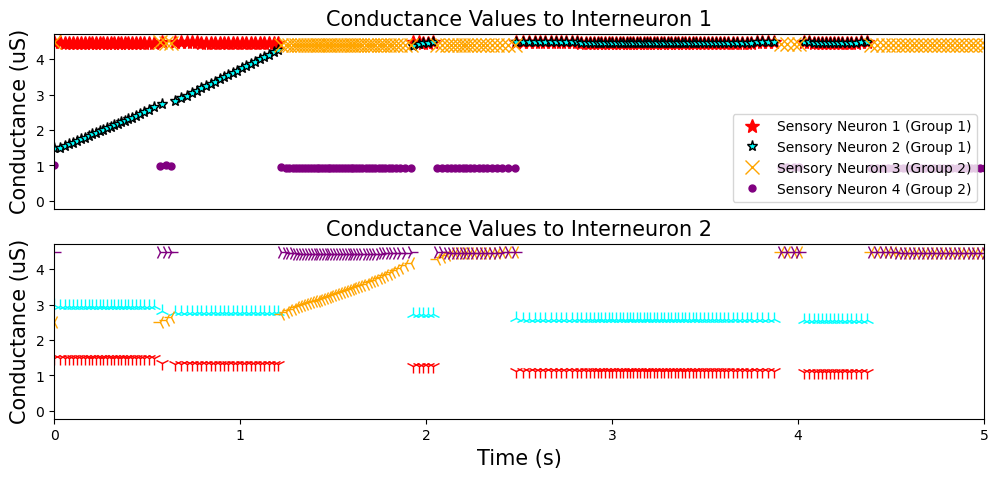

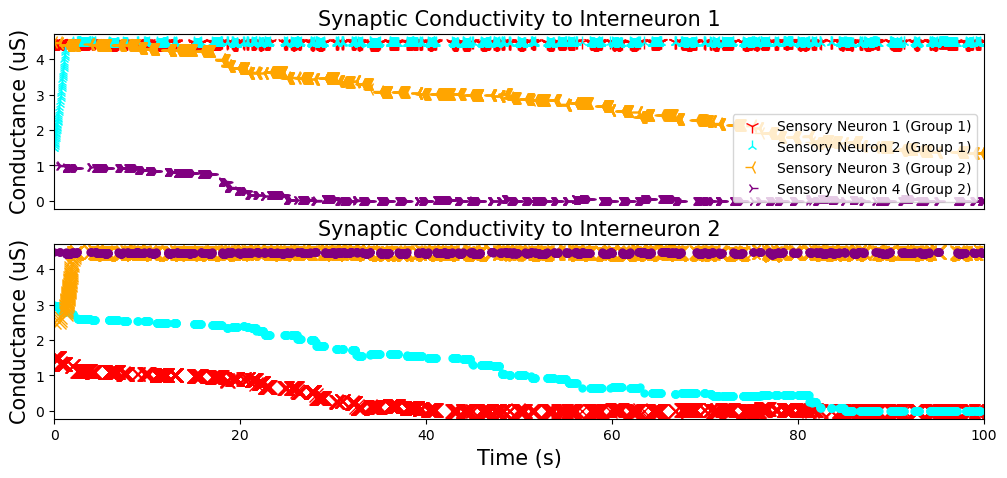

In [24]:

''' Plot of Synaptic Conductance values from Ia Afferents to Interneurons '''
# Conductance values connecting TO POST1 / Interneuron 1
plt.figure(figsize=[12, 5]) # 27 12
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.2)
plt.title(label='Conductance Values to Interneuron 1', size='15')
plt.plot(plot_IN1_t, plot_IN1_POST1, '*', label='Sensory Neuron 1 (Group 1)', markersize=10, linewidth=1, color='red')
plt.plot(plot_IN2_t, plot_IN2_POST1, '*', label='Sensory Neuron 2 (Group 1)', markersize=8, markeredgecolor='black', color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST1, 'x', label='Sensory Neuron 3 (Group 2)', markersize=10, color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST1, '.', label='Sensory Neuron 4 (Group 2)', markersize=10, color='purple')
plt.xlim(plot_x_min, plot_x_max_sns)
plt.xticks(ticks=[])
plt.legend(loc='lower right')
# plt.xlabel(xlabel='Time (ms)')
plt.ylabel(ylabel='Conductance (uS)', size='15')
# Conductance values connecting TO POST2 / Inteneuron 2
plt.subplot(2, 1, 2)
plt.title(label='Conductance Values to Interneuron 2', size='15')
plt.plot(plot_IN1_t, plot_IN1_POST2, '1', label='Sensory Neuron 1', markersize=10, color='red')
plt.plot(plot_IN2_t, plot_IN2_POST2, '2', label='Sensory Neuron 2', markersize=10, color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST2, '3', label='Sensory Neuron 3', markersize=10, color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST2, '4', label='Sensory Neuron 4', markersize=10, color='purple')
plt.xlim(plot_x_min, plot_x_max_sns)
plt.xticks(ticks=[0, 1000, 2000, 3000, 4000, 5000], labels=[0, 1, 2, 3, 4, 5])
# plt.legend(loc='upper right')
plt.xlabel(xlabel='Time (s)', size='15')
plt.ylabel(ylabel='Conductance (uS)', size='15')

plt.savefig('ShortTrial.png', dpi=600)

plt.show()

''' FULL Time Duration '''
plot_x_max_sns_c = plot_x_max_sns * 20

''' Plot of Synaptic Conductance values from Ia Afferents to Interneurons '''
# Conductance values connecting TO POST1 / Interneuron 1
plt.figure(figsize=[12, 5]) # 27 12
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.2)
plt.title(label='Synaptic Conductivity to Interneuron 1', size='15')
plt.plot(plot_IN1_t, plot_IN1_POST1, '1', label='Sensory Neuron 1 (Group 1)', markersize=10, color='red')
plt.plot(plot_IN2_t, plot_IN2_POST1, '2', label='Sensory Neuron 2 (Group 1)', markersize=8, color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST1, '3', label='Sensory Neuron 3 (Group 2)', markersize=10, color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST1, '4', label='Sensory Neuron 4 (Group 2)', markersize=8, color='purple')
plt.xlim(plot_x_min, plot_x_max_sns_c)
plt.xticks(ticks=[])
plt.legend(loc='lower right')
# plt.xlabel(xlabel='Time (ms)')
plt.ylabel(ylabel='Conductance (uS)', size='15')

# Conductance values connecting TO POST2 / Inteneuron 2
plt.subplot(2, 1, 2)
plt.title(label='Synaptic Conductivity to Interneuron 2', size='15')
plt.plot(plot_IN1_t, plot_IN1_POST2, 'x', label='Sensory Neuron 1', markersize=10, color='red')
plt.plot(plot_IN2_t, plot_IN2_POST2, '.', label='Sensory Neuron 2', markersize=10, color='cyan')
plt.plot(plot_IN3_t, plot_IN3_POST2, 'x', label='Sensory Neuron 3', markersize=10, color='orange')
plt.plot(plot_IN4_t, plot_IN4_POST2, '.', label='Sensory Neuron 4', markersize=10, color='purple')
plt.xlim(plot_x_min, plot_x_max_sns_c)
plt.xticks(ticks=[0, 20000, 40000, 60000, 80000, 100000], labels=[0, 20, 40, 60, 80, 100])
# plt.legend(loc='upper right')
plt.xlabel(xlabel='Time (s)', size='15')
plt.ylabel(ylabel='Conductance (uS)', size='15')

plt.savefig('LongTrial.png', dpi=600)

plt.show()

Synaptic Strength Change.

In [25]:

# Display the strength of synaptic conenctions
print(g_start)
# print(g_update)
print('1 & 2 to Post 1: ' + str(g_start[4][0] + g_start[4][1]))
print('3 & 4 to Post 1: ' + str(g_start[4][2] + g_start[4][3]))
print('1 & 2 to Post 2: ' + str(g_start[5][0] + g_start[5][1]))
print('3 & 4 to Post 2: ' + str(g_start[5][2] + g_start[5][3]))

[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [4.5  1.5  4.5  1.   0.   0.  ]
 [1.5  2.98 2.5  4.5  0.   0.  ]]
1 & 2 to Post 1: 6.0
3 & 4 to Post 1: 5.5
1 & 2 to Post 2: 4.48
3 & 4 to Post 2: 7.0


Additional plot changes as requested for papers.

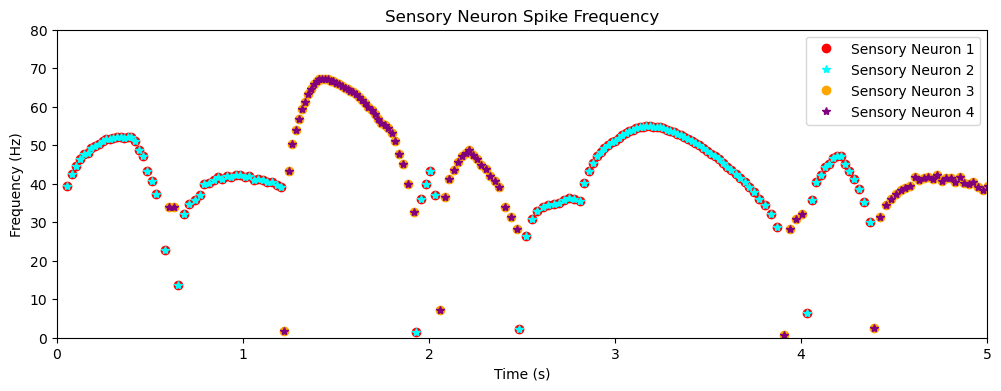

In [26]:

''' Ia Afferent Spike Frequency Plot '''
# IN1 and IN2 Spike Frequency
plt.figure(figsize=[12, 4]) # 27, 7

plt.plot(IN1_loc, IN1_freq, 'o', color='red', label='Sensory Neuron 1')
plt.plot(IN2_loc, IN2_freq, '*', color='cyan', label='Sensory Neuron 2')
plt.plot(IN3_loc, IN3_freq, 'o', color='orange', label='Sensory Neuron 3')
plt.plot(IN4_loc, IN4_freq, '*', color='purple', label='Sensory Neuron 4')

plt.xticks(ticks=[0, 1000, 2000, 3000, 4000, 5000], labels=[0, 1, 2, 3, 4, 5])

plt.title('Sensory Neuron Spike Frequency')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 80)
plt.xlim(plot_x_min, plot_x_max_sns)
plt.legend(loc='upper right')

plt.savefig('IaSpikeFreq.png', dpi=600)

plt.show()


Saving video of simulation.

In [27]:

# Cut down to 10 seconds
# media.show_video(frames[0:599], fps=framerate)

# # Output file name
# output_name = 'LegSimulation.mp4'
# # Write frames to video
# media.write_video(output_name, images=frames[0:599], fps=60, )